<a href="https://colab.research.google.com/github/iremond/Progetto_HLT/blob/main/subtaskA/Distilbert_multi_doppio_val_model_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys

!{sys.executable} -m pip install transformers[torch] datasets evaluate torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 40.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 42.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 58.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 59.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.3 MB/s eta 0:00:00


In [5]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, BertConfig, AutoConfig
import numpy as np
import evaluate
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


# Data loading

In [6]:
df_dev = load_dataset("csv", data_files="subtaskA_clean_dev_cased.csv")
df_test = load_dataset("csv", data_files="subtaskA_clean_test_cased.csv")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

# Data partioning

In [7]:
train_val = df_dev['train'].train_test_split(test_size=0.3, seed=0)
train_val

DatasetDict({
    train: Dataset({
        features: ['comment_text', 'conspiratorial'],
        num_rows: 1288
    })
    test: Dataset({
        features: ['comment_text', 'conspiratorial'],
        num_rows: 552
    })
})

In [8]:
df_train = train_val["train"]
df_val_ = train_val["test"]

In [9]:
df_train = df_train.rename_column("comment_text", "text")
df_train = df_train.rename_column("conspiratorial", "labels")
df_val_ = df_val_.rename_column("comment_text", "text")
df_val_ = df_val_.rename_column("conspiratorial", "labels")
df_test = df_test.rename_column("comment_text", "text")

In [10]:
df_val_

Dataset({
    features: ['text', 'labels'],
    num_rows: 552
})

In [11]:
df_val_ = df_val_.train_test_split(test_size=0.3, seed=0)

In [12]:
df_val_

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 386
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 166
    })
})

In [13]:
df_val = df_val_["train"]
df_val2 = df_val_["test"]

In [14]:
df_train

Dataset({
    features: ['text', 'labels'],
    num_rows: 1288
})

In [15]:
df_val

Dataset({
    features: ['text', 'labels'],
    num_rows: 386
})

In [16]:
df_val2

Dataset({
    features: ['text', 'labels'],
    num_rows: 166
})

# Model loading

In [17]:
nome = 'distilbert_base_ita' # modificare
model_name = 'Geotrend/distilbert-base-it-cased'

In [18]:
# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Data preprocessing

In [19]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

In [20]:
tokenized_train = df_train.map(tokenize_function, batched=True)
tokenized_val = df_val.map(tokenize_function, batched=True)
tokenized_val2 = df_val2.map(tokenize_function, batched=True)

Map:   0%|          | 0/1288 [00:00<?, ? examples/s]

Map:   0%|          | 0/386 [00:00<?, ? examples/s]

Map:   0%|          | 0/166 [00:00<?, ? examples/s]

# Hyperparameter Search

In [26]:
def hyperparameter_search(model_name=model_name, optim='adamw_hf', learning_rate=0.00005, dropout=0.1, index=0):
# inserire i parametri di default del modello
    training_args = TrainingArguments(
            output_dir=f"{nome}-finetuned/run_{index}",
            evaluation_strategy = "epoch", # monitor the evaluation metrics during fine-tuning at the end of each epoch
            save_strategy = "epoch",
            logging_strategy="epoch",
            num_train_epochs=15,
            load_best_model_at_end=True, # the best model might not be the one at the end of training => we load the best saved model
            metric_for_best_model='eval_f1',
            seed=42,
            optim=optim,
            learning_rate=learning_rate # default 0.00005
            #per_device_train_batch_size # default 8
            #per_device_eval_batch_size # default 8
            #weight_decay=0.0001 # default 0 # disastro
            )
    config = AutoConfig.from_pretrained(model_name)
    config.dropout = dropout
    model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config)
    return training_args, model

In [27]:
def compute_metrics(eval_pred):
  # takes as input model predictions, applies argmax to them and comput F-Score between predictions and true labels
  f1_metric = evaluate.load("f1")
  predictions, labels = eval_pred
  predictions = np.argmax(predictions, axis=1)
  return f1_metric.compute(predictions=predictions, references=labels, average="macro")

In [29]:
%%time
dropout_values = [0.05, 0.1, 0.2]
learning_rate_values = [0.00003, 0.00005, 0.00007]
histories = {}
i = 0
for dropout_value in dropout_values:
  for learning_rate_value in learning_rate_values:
    if not (learning_rate_value == 0.00005 and dropout_value == 0.1): # configurazione di default, che non ci serve testare
      i += 1
      training_args, model = hyperparameter_search(dropout=dropout_value, learning_rate=learning_rate_value, index=i)
      trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_val,
        compute_metrics=compute_metrics)
      trainer.train()
      log_history = trainer.state.log_history
      histories[f'Dropout_{dropout_value}_LR_{learning_rate_value}'] = log_history

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at Geotrend/distilbert-base-it-cased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1
1,0.581800,0.502679,0.776187
2,0.433900,0.501403,0.800292
3,0.254600,0.909031,0.774533
4,0.123100,1.041831,0.792657
5,0.066500,1.162711,0.797879
6,0.021700,1.280649,0.789748
7,0.002800,1.402470,0.792746
8,0.003100,1.459671,0.792294
9,0.002600,1.481002,0.797384
10,0.002300,1.532023,0.790120


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at Geotrend/distilbert-base-it-cased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1
1,0.602600,0.492366,0.769019
2,0.456300,0.501134,0.790018
3,0.263300,0.910561,0.763480
4,0.112400,1.146729,0.763676
5,0.044200,1.361561,0.783754
6,0.025600,1.387590,0.770815
7,0.009800,1.456588,0.788416
8,0.011900,1.579858,0.778543
9,0.004000,1.656728,0.776909
10,0.008600,1.703617,0.779791


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at Geotrend/distilbert-base-it-cased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1
1,0.613100,0.546222,0.749143
2,0.527100,0.544776,0.689213
3,0.469300,0.538051,0.777196
4,0.302100,0.799131,0.747151
5,0.181700,0.964469,0.774574
6,0.106000,1.045211,0.779008
7,0.089600,1.193921,0.764794
8,0.046200,1.375666,0.755821
9,0.027700,1.493237,0.772015
10,0.023100,1.415573,0.775880


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at Geotrend/distilbert-base-it-cased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1
1,0.586900,0.487973,0.776187
2,0.417200,0.503831,0.800216
3,0.281800,0.787648,0.790143
4,0.118900,1.270711,0.733923
5,0.047800,1.257318,0.762062
6,0.014500,1.537370,0.768296
7,0.012700,1.551072,0.766331
8,0.003400,1.612004,0.784973
9,0.002800,1.650636,0.784857
10,0.002500,1.798841,0.769081


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at Geotrend/distilbert-base-it-cased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1
1,0.621900,0.567936,0.757700
2,0.492500,0.520996,0.774598
3,0.281300,0.789298,0.771868
4,0.135500,1.204192,0.743508
5,0.047700,1.416106,0.763791
6,0.018800,1.700965,0.768609
7,0.007300,1.868726,0.753009
8,0.005800,1.944119,0.758599
9,0.002600,2.014006,0.753155
10,0.002400,2.071088,0.753155


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at Geotrend/distilbert-base-it-cased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1
1,0.587100,0.494649,0.773703
2,0.461600,0.469340,0.789124
3,0.323700,0.597537,0.777202
4,0.192800,1.030154,0.754093
5,0.103800,1.259778,0.760701
6,0.051500,1.529132,0.758988
7,0.026600,1.601189,0.765606
8,0.024200,1.632793,0.772743
9,0.023100,1.620573,0.774173
10,0.005600,1.704661,0.771800


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at Geotrend/distilbert-base-it-cased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1
1,0.602000,0.493437,0.744240
2,0.464800,0.462672,0.784556
3,0.308600,0.697709,0.802977
4,0.179200,1.026480,0.756418
5,0.079900,1.305386,0.786997
6,0.050600,1.883265,0.720702
7,0.032700,1.496650,0.796699
8,0.010400,1.511060,0.797732
9,0.008100,1.609897,0.797143
10,0.003000,1.654747,0.800130


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at Geotrend/distilbert-base-it-cased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1
1,0.617600,0.512103,0.746331
2,0.523500,0.486342,0.779460
3,0.379800,0.672696,0.777106
4,0.216200,0.967071,0.750162
5,0.134800,1.075041,0.774173
6,0.050200,1.475007,0.756451
7,0.033200,1.734292,0.756040
8,0.025300,1.800549,0.744589
9,0.021800,1.993068,0.740249
10,0.013900,1.860046,0.750968


CPU times: user 2h 8min 27s, sys: 2min 9s, total: 2h 10min 36s
Wall time: 2h 27min 15s


## Riassunto performance sul val1
* Dropout = 0.05; learning rate = 0.00003:
  * loss minore = 0,501 (seconda epoca);
  * F1 maggiore = 0,8 (seconda epoca);
* Dropout = 0.05, learning_rate = 0.00005:
  * loss minore = 0,501 (seconda epoca);
  * F1 maggiore = 0,79 (seconda epoca);
* Dropout = 0.05, learning_rate = 0.00007:
  * loss minore = 0,538 (terza epoca, con F1 = 0,777);
  * F1 maggiore = 0,779 (sesta epoca);
* Dropout = 0.1, learning_rate = 0.00003:
  * loss minore = 0,488 (prima epoca, con F1 = 0,776);
  * F1 maggiore = 0,8 (seconda epoca);
* Dropout = 0.1, learning_rate = 0.00007:
  * loss minore = 0.521 (seconda epoca, con F1 = 0,775)
  * F1 maggiore = 0,775 (seconda epoca)
* Dropout = 0.2, learning_rate = 0.00003:
  * loss minore = 0.469 (seconda epoca)
  * F1 maggiore = 0.789 (seconda epoca)
* Dropout = 0.2, learning_rate = 0.00005:
  * loss minore = 0.463 (seconda epoca, con F1 = 0,785)
  * F1 maggiore = 0,803 (terza epoca);
* Dropout = 0.2, learning_rate = 0.00007:
  * loss minore = 0,486 (seconda epoca, con F1 = 0,779)
  * F1 maggiore = 0,779 (seconda epoca).

# Evaluation

In [ ]:
for log_history in histories:
  print(log_history)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-55-30d89525c7b4>", line 2, in <cell line: 1>
    print(log_history.keys())
AttributeError: 'str' object has no attribute 'keys'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'AttributeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/usr/local/lib/python3.10/dist-pa

In [ ]:
for log_history in histories: # ciclo sui modelli
  df = pd.DataFrame(columns=["Epoch", "Loss", "Dataset"])

  for log_data in log_history:
    epoch = int(log_data["epoch"])
    if "loss" in log_data.keys():
      loss = log_data["loss"]
      df = df.append({"Epoch": epoch, "Loss": loss, "Dataset": "Training"}, ignore_index=True)
    if "eval_loss" in log_data.keys():
      loss = log_data["eval_loss"]
      df = df.append({"Epoch": epoch, "Loss": loss, "Dataset": "Validation"}, ignore_index=True)

  # loss lineplot
  sns.lineplot(data=df, x="Epoch", y="Loss", hue="Dataset")
  plt.xticks(range(1, 16))
  plt.xlabel('Epoca')
  #plt.savefig(f'loss_curves_{nome}_doppioval.pdf', dpi=300, bbox_inches='tight')

  plt.show()
  #df

<ipython-input-32-47d9dd4e1fd7>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Epoch": epoch, "Loss": loss, "Dataset": "Training"}, ignore_index=True)
<ipython-input-32-47d9dd4e1fd7>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Epoch": epoch, "Loss": loss, "Dataset": "Validation"}, ignore_index=True)
<ipython-input-32-47d9dd4e1fd7>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Epoch": epoch, "Loss": loss, "Dataset": "Training"}, ignore_index=True)
<ipython-input-32-47d9dd4e1fd7>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Epoch": epoch, "Loss": loss, "Da

In [ ]:
#df.to_html(f'loss_{nome}.html')

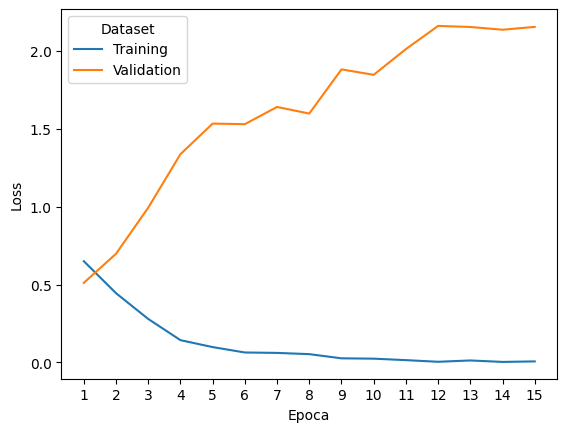

In [ ]:
# loss lineplot
sns.lineplot(data=df, x="Epoch", y="Loss", hue="Dataset")
plt.xticks(range(1, 16))
plt.xlabel('Epoca')
plt.savefig(f'loss_curves_{nome}_doppioval.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
output_predictions = trainer.predict(tokenized_val2)

In [ ]:
y_val = tokenized_val2["labels"]
y_val_pred = np.argmax(output_predictions.predictions, axis=1)

report = classification_report(y_val, y_val_pred)
print(report)

              precision    recall  f1-score   support

           0       0.64      0.69      0.67        81
           1       0.68      0.64      0.66        85

    accuracy                           0.66       166
   macro avg       0.66      0.66      0.66       166
weighted avg       0.66      0.66      0.66       166



L'f1-score sul secondo validation è dello 0,66, mentre sul primo era dello 0,75788 :(

In [ ]:
with open(f"class_report_{nome}_doppioval.html", "w") as file:
    file.write(report)

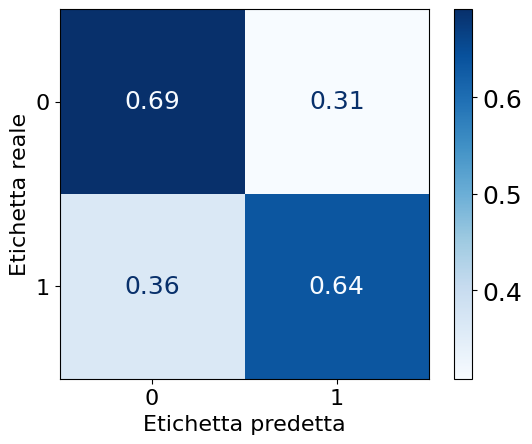

In [ ]:
plt.rcParams.update({'font.size': 18})
ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred, cmap='Blues', normalize='true')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Etichetta predetta', fontsize=16)
plt.ylabel('Etichetta reale', fontsize=16)
plt.savefig(f'conf_matrix_{nome}_doppioval.pdf', dpi=300, bbox_inches='tight')
plt.show()

# Valutazione di TUTTI i modelli creati

## Primo modello

Carichiamo il modello della seconda epoca, in quanto migliore.

In [37]:
first_model_directory = 'distilbert_base_ita-finetuned/run_1/checkpoint-805'

In [39]:
first_model = AutoModelForSequenceClassification.from_pretrained(first_model_directory)
trainer = Trainer(model=first_model)
output_prediction = trainer.predict(tokenized_val2)

In [42]:
y_val = tokenized_val2["labels"]
y_val_pred = np.argmax(output_prediction.predictions, axis=1)

first_model_report = classification_report(y_val, y_val_pred)
print(first_model_report)

              precision    recall  f1-score   support

           0       0.68      0.68      0.68        81
           1       0.69      0.69      0.69        85

    accuracy                           0.69       166
   macro avg       0.69      0.69      0.69       166
weighted avg       0.69      0.69      0.69       166



## Secondo modello

In [43]:
second_model_directory = 'distilbert_base_ita-finetuned/run_2/checkpoint-805'
second_model = AutoModelForSequenceClassification.from_pretrained(second_model_directory)
trainer = Trainer(model=second_model)
output_prediction = trainer.predict(tokenized_val2)
y_val = tokenized_val2["labels"]
y_val_pred = np.argmax(output_prediction.predictions, axis=1)

second_model_report = classification_report(y_val, y_val_pred)
print(second_model_report)

              precision    recall  f1-score   support

           0       0.70      0.60      0.65        81
           1       0.67      0.75      0.71        85

    accuracy                           0.68       166
   macro avg       0.68      0.68      0.68       166
weighted avg       0.68      0.68      0.68       166



## Terzo modello

In [44]:
third_model_f1_directory = 'distilbert_base_ita-finetuned/run_3/checkpoint-2415'
third_model_f1 = AutoModelForSequenceClassification.from_pretrained(third_model_f1_directory)
trainer = Trainer(model=third_model_f1)
output_prediction = trainer.predict(tokenized_val2)
y_val = tokenized_val2["labels"]
y_val_pred = np.argmax(output_prediction.predictions, axis=1)

third_model_f1_report = classification_report(y_val, y_val_pred)
print(third_model_f1_report)

              precision    recall  f1-score   support

           0       0.66      0.72      0.69        81
           1       0.71      0.65      0.67        85

    accuracy                           0.68       166
   macro avg       0.68      0.68      0.68       166
weighted avg       0.68      0.68      0.68       166



In [45]:
third_model_loss_directory = 'distilbert_base_ita-finetuned/run_3/checkpoint-644'
third_model_loss = AutoModelForSequenceClassification.from_pretrained(third_model_loss_directory)
trainer = Trainer(model=third_model_loss)
output_prediction = trainer.predict(tokenized_val2)
y_val = tokenized_val2["labels"]
y_val_pred = np.argmax(output_prediction.predictions, axis=1)

third_model_loss_report = classification_report(y_val, y_val_pred)
print(third_model_loss_report)

              precision    recall  f1-score   support

           0       0.80      0.54      0.65        81
           1       0.67      0.87      0.76        85

    accuracy                           0.71       166
   macro avg       0.73      0.71      0.70       166
weighted avg       0.73      0.71      0.70       166



## Quarto modello

In [46]:
fourth_model_f1_directory = 'distilbert_base_ita-finetuned/run_4/checkpoint-805'
fourth_model_f1 = AutoModelForSequenceClassification.from_pretrained(fourth_model_f1_directory)
trainer = Trainer(model=fourth_model_f1)
output_prediction = trainer.predict(tokenized_val2)
y_val = tokenized_val2["labels"]
y_val_pred = np.argmax(output_prediction.predictions, axis=1)

fourth_model_f1_report = classification_report(y_val, y_val_pred)
print(fourth_model_f1_report)

              precision    recall  f1-score   support

           0       0.73      0.59      0.65        81
           1       0.67      0.79      0.72        85

    accuracy                           0.69       166
   macro avg       0.70      0.69      0.69       166
weighted avg       0.70      0.69      0.69       166



In [48]:
fourth_model_loss_directory = 'distilbert_base_ita-finetuned/run_4/checkpoint-966'
fourth_model_loss = AutoModelForSequenceClassification.from_pretrained(fourth_model_loss_directory)
trainer = Trainer(model=fourth_model_loss)
output_prediction = trainer.predict(tokenized_val2)
y_val = tokenized_val2["labels"]
y_val_pred = np.argmax(output_prediction.predictions, axis=1)

fourth_model_loss_report = classification_report(y_val, y_val_pred)
print(fourth_model_loss_report)

              precision    recall  f1-score   support

           0       0.65      0.74      0.69        81
           1       0.72      0.62      0.67        85

    accuracy                           0.68       166
   macro avg       0.68      0.68      0.68       166
weighted avg       0.68      0.68      0.68       166



## Quinto modello

In [49]:
directory = 'distilbert_base_ita-finetuned/run_5/checkpoint-805'
model = AutoModelForSequenceClassification.from_pretrained(directory)
trainer = Trainer(model=model)
output_prediction = trainer.predict(tokenized_val2)
y_val = tokenized_val2["labels"]
y_val_pred = np.argmax(output_prediction.predictions, axis=1)

report = classification_report(y_val, y_val_pred)
print(report)

              precision    recall  f1-score   support

           0       0.67      0.65      0.66        81
           1       0.68      0.69      0.69        85

    accuracy                           0.67       166
   macro avg       0.67      0.67      0.67       166
weighted avg       0.67      0.67      0.67       166



## Sesto modello

In [50]:
directory = 'distilbert_base_ita-finetuned/run_6/checkpoint-805'
model = AutoModelForSequenceClassification.from_pretrained(directory)
trainer = Trainer(model=model)
output_prediction = trainer.predict(tokenized_val2)
y_val = tokenized_val2["labels"]
y_val_pred = np.argmax(output_prediction.predictions, axis=1)

report = classification_report(y_val, y_val_pred)
print(report)

              precision    recall  f1-score   support

           0       0.80      0.59      0.68        81
           1       0.69      0.86      0.76        85

    accuracy                           0.73       166
   macro avg       0.74      0.73      0.72       166
weighted avg       0.74      0.73      0.72       166



## Settimo modello

In [51]:
directory = 'distilbert_base_ita-finetuned/run_7/checkpoint-644'
model = AutoModelForSequenceClassification.from_pretrained(directory)
trainer = Trainer(model=model)
output_prediction = trainer.predict(tokenized_val2)
y_val = tokenized_val2["labels"]
y_val_pred = np.argmax(output_prediction.predictions, axis=1)

report = classification_report(y_val, y_val_pred)
print(report)

              precision    recall  f1-score   support

           0       0.69      0.67      0.68        81
           1       0.69      0.72      0.71        85

    accuracy                           0.69       166
   macro avg       0.69      0.69      0.69       166
weighted avg       0.69      0.69      0.69       166



In [52]:
directory = 'distilbert_base_ita-finetuned/run_7/checkpoint-805'
model = AutoModelForSequenceClassification.from_pretrained(directory)
trainer = Trainer(model=model)
output_prediction = trainer.predict(tokenized_val2)
y_val = tokenized_val2["labels"]
y_val_pred = np.argmax(output_prediction.predictions, axis=1)

report = classification_report(y_val, y_val_pred)
print(report)

              precision    recall  f1-score   support

           0       0.77      0.59      0.67        81
           1       0.68      0.84      0.75        85

    accuracy                           0.72       166
   macro avg       0.73      0.71      0.71       166
weighted avg       0.73      0.72      0.71       166



## Ottavo modello

In [53]:
directory = 'distilbert_base_ita-finetuned/run_7/checkpoint-805'
model = AutoModelForSequenceClassification.from_pretrained(directory)
trainer = Trainer(model=model)
output_prediction = trainer.predict(tokenized_val2)
y_val = tokenized_val2["labels"]
y_val_pred = np.argmax(output_prediction.predictions, axis=1)

report = classification_report(y_val, y_val_pred)
print(report)

              precision    recall  f1-score   support

           0       0.77      0.59      0.67        81
           1       0.68      0.84      0.75        85

    accuracy                           0.72       166
   macro avg       0.73      0.71      0.71       166
weighted avg       0.73      0.72      0.71       166

